# The preceeding ipynb is semi more general in selecting it's blurring region.
# It is capable of selecting cuboid, i.e. unequal sides
# This ipynb restricts to only cubes, i.e. equal sides, as an attempt to be more computationally efficient
# The reason for this restriction relies on the assumption that the blurring region are spheres

## Importing Libraries

In [99]:
%matplotlib inline
import matplotlib.pyplot as plt
import logging
import numpy as np
import py21cmfast as p21c

## Cosmological Parameters (Default is used when no input is specified)

In [100]:
cosmo_params = p21c.CosmoParams()

## User Parameters, like box length, number of voxels (i.e. resolution) etc.

In [101]:
user_params = p21c.UserParams(
    BOX_LEN=301,  # Box length
    DIM=2*301,      # Number of Voxels for hight resolution 
    HII_DIM=301  # Number of Voxels for low resolution 
)

## Creating initial conditions box

In [102]:
init_cond = p21c.initial_conditions(
    cosmo_params=cosmo_params,
    user_params=user_params
)

## Gaussian function

In [103]:
def Gaussian(x, sigma):  # μ=0, σ=1/sqrt(2), π=1
    Gaussian = np.exp(-(x/sigma)**2)
    return Gaussian

## Measure the distance of each voxel to the center

In [104]:
def distance_from_coordinate(box_length):
    
    index = np.arange(-0.5*(box_length-1), 0.5*(box_length+1))

    x_mesh, y_mesh, z_mesh = np.meshgrid(index, index, index, indexing='ij')
    
    distance = np.sqrt((x_mesh)**2 + (y_mesh)**2 + (z_mesh)**2)
    
    return distance

## Random Coordinate

In [105]:
def random_voxel(box_length):
    
    np.random.seed()  # set seed to a randome number
#     np.random.seed(4) ; np.random.rand(10)

    coordinate = np.random.randint(0, box_length, size=3)

    return coordinate

## Select a Smaller Cube with Sides 2R+1 Voxels, Centered about the Random Coordinate

In [106]:
def cube_centered_about_coordinate(coordinate_array, radius, box):
    x_ind1 = coordinate_array[0]-radius  # x-domian
    x_ind2 = coordinate_array[0]+radius+1  # ending index is not inclusive
    y_ind1 = coordinate_array[1]-radius  # y-domain
    y_ind2 = coordinate_array[1]+radius+1
    z_ind1 = coordinate_array[2]-radius  # z-domain
    z_ind2 = coordinate_array[2]+radius+1

    if x_ind1 < 0:  # periodic boundary conditions
        x_inds = np.r_[(x_ind1+len(box)):len(box), 0:x_ind2]
    elif x_ind2 > len(box):
        x_inds = np.r_[x_ind1:len(box), 0:(x_ind2-len(box))]
    else:
        x_inds = np.r_[x_ind1:x_ind2]

    if y_ind1 < 0:
        y_inds = np.r_[(y_ind1+len(box)):len(box), 0:y_ind2]
    elif y_ind2 > len(box):
        y_inds = np.r_[y_ind1:len(box), 0:(y_ind2-len(box))]
    else:
        y_inds = np.r_[y_ind1:y_ind2]

    if z_ind1 < 0:
        z_inds = np.r_[(z_ind1+len(box)):len(box), 0:z_ind2]
    elif z_ind2 > len(box):
        z_inds = np.r_[z_ind1:len(box), 0:(z_ind2-len(box))]
    else:
        z_inds = np.r_[z_ind1:z_ind2]

    indices = np.ix_(x_inds, y_inds, z_inds)
        
    output_box = box[indices]
    
    return output_box

## Gausssian Sphere Averaging

In [107]:
def gaussian_sphere_average(distance_box, radius, input_box, shell_num, sigma_factor):
    
    mean = []

    shell_radius_edges = np.linspace(0,1,shell_num+1)
    shell_center = 0.5*(shell_radius_edges[1:] + shell_radius_edges[:-1])*sigma_factor*radius  # sigma_factor number of sigmas the weighting goes out to, sigma = radius
    weight = Gaussian(x=shell_center, sigma=radius)

    for ii in range(shell_num):
        condition = np.logical_and(distance_box <= shell_radius_edges[ii+1]*radius, distance_box > shell_radius_edges[ii]*radius)
        inside_shell_mean = np.mean(input_box[condition])
        mean = np.append(mean, inside_shell_mean)
        
    Gaussian_mean = np.average(mean, weights=weight)
    
    return Gaussian_mean

## Top Hat Sphere Averaging

In [108]:
def top_hat_sphere_average(distance_box, radius, input_box):
    
    condition = distance_box <= radius
    mean = np.mean(input_box[condition])
    
    return mean

## Top Hat Cube Averaging

In [109]:
def top_hat_cube_average(input_box):
    
    mean = np.mean(input_box)
    
    return mean

## Sphere Blurring Function

In [110]:
def Average_Neutral_Fraction_Distribution(box, radius, iteration, shell_num=6, sigma_factor=4, blur_shape=None):
    
    box = box.copy()  # make copy of input box to have a separate box
    
    mean_data = []  # empty list for data collection
    
    if blur_shape == 'Gaussian_sphere':
        dist_frm_coord_box = distance_from_coordinate(radius*2+1)
        for i in range(iteration):
            rand_coord = random_voxel(len(box))
            cube_region_box = cube_centered_about_coordinate(rand_coord, radius, box)
            mean = gaussian_sphere_average(dist_frm_coord_box, radius, cube_region_box, shell_num, sigma_factor)
            mean_data = np.append(mean_data, mean)
        
    elif blur_shape == 'top_hat_sphere':
        radius = int(round(radius*((3*np.sqrt(np.pi)/4)**(1/3))))  # ratio numerically calculated.
        dist_frm_coord_box = distance_from_coordinate(radius*2+1)
        for i in range(iteration):
            rand_coord = random_voxel(len(box))
            cube_region_box = cube_centered_about_coordinate(rand_coord, radius, box)
            mean = top_hat_sphere_average(dist_frm_coord_box, radius, cube_region_box)
            mean_data = np.append(mean_data, mean)
            
    elif blur_shape == 'top_hat_cube':
        radius = int(round((radius*np.sqrt(np.pi)-1)/2))  # ratio determiend by equating the volumes of cube & sphere
        for i in range(iteration):
            rand_coord = random_voxel(len(box))
            cube_region_box = cube_centered_about_coordinate(rand_coord, radius, box)
            mean = top_hat_cube_average(cube_region_box)
            mean_data = np.append(mean_data, mean)
    else:
        print('Blurring shape assumed to be a Gaussian sphere with 4 shells weighted by equally spaced values from 0 sigma to 4 sigma.')
        dist_frm_coord_box = distance_from_coordinate(radius*2+1)
        for i in range(iteration):
            rand_coord = random_voxel(len(box))
            cube_region_box = cube_centered_about_coordinate(rand_coord, radius, box)
            mean = gaussian_sphere_average(dist_frm_coord_box, radius, cube_region_box, shell_num, sigma_factor)
            mean_data = np.append(mean_data, mean)
            
    return mean_data

## Histogram Function

In [410]:
def histogram(fs, title, figure_shape, x_start=0, x_stop=1, bin_num=100, color='white', figure_size=(18,7), font_size=15, horizontal_gap=0.05, vertical_gap=0.05, y_scale='linear', y_notation='plain', sharex=True, sharey=True):  # a: x start, b: x stop
    bin_edges = np.linspace(x_start, x_stop, bin_num) # 100 bins from 0-1
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    if type(fs) is tuple:  # hopefully more robust condition.
        fig, axes = plt.subplots(figure_shape[0], figure_shape[1], figsize=figure_size, sharex=sharex, sharey=sharey, gridspec_kw={"hspace":vertical_gap, 'wspace':horizontal_gap})
        for i, f in enumerate(fs):
            axes.flatten()[i].plot(bin_centers, np.histogram(f, bins=bin_edges)[0])
            axes.flatten()[i].set_title(title[i], color=color, fontsize=font_size)
            axes.flatten()[i].tick_params(color=color, labelcolor=color, labelsize=font_size)  # figure color
            axes.flatten()[i].set_yscale(y_scale)
            if y_scale is not 'log':
                axes.flatten()[i].ticklabel_format(axis='y', style=y_notation, scilimits=(0,0), useMathText=True)
            for spine in axes.flatten()[i].spines.values():
                spine.set_edgecolor(color)
    else:
        fig, ax = plt.subplots(figsize=figure_size)
        ax.plot(bin_centers, np.histogram(fs, bins=bin_edges)[0])
        ax.set_title(title, color=color, fontsize=font_size)
        ax.tick_params(color=color, labelcolor=color, labelsize=font_size)  # figure color
        ax.set_yscale(y_scale)
        if y_scale is not 'log':
            ax.ticklabel_format(axis='y', style=y_notation, scilimits=(0,0), useMathText=True)
        for spine in ax.spines.values():
            spine.set_edgecolor(color)

## Plots

In [411]:
def plots(x_vals, fs, title, y_label, figure_shape, color='white', figure_size=(18,7), font_size=15, horizontal_gap=0.05, vertical_gap=0.05, y_scale='linear', y_notation='plain', sharex=True, sharey=True):  # a: x start, b: x stop
    if type(fs) is tuple:  # hopefully more robust condition.
        fig, axes = plt.subplots(figure_shape[0], figure_shape[1], figsize=figure_size, sharex=sharex, sharey=sharey, gridspec_kw={"hspace":vertical_gap, 'wspace':horizontal_gap})
        for i, f in enumerate(fs):
            axes.flatten()[i].plot(x_vals, f)
            axes.flatten()[i].set_title(title[i], color=color, fontsize=font_size)
            axes.flatten()[i].set_ylabel(y_label[i], color=color, fontsize=font_size)
            axes.flatten()[i].tick_params(color=color, labelcolor=color, labelsize=font_size, size=font_size)  # figure color
            axes.flatten()[i].set_yscale(y_scale)
            if y_scale is not 'log':
                axes.flatten()[i].ticklabel_format(axis='y', style=y_notation[i], scilimits=(0,0), useMathText=True)
            for spine in axes.flatten()[i].spines.values():
                spine.set_edgecolor(color)
    else:
        fig, ax = plt.subplots(figsize=figure_size)
        ax.plot(x_vals, fs)
        ax.set_title(title, color=color, fontsize=font_size)
        ax.set_ylabel(y_label, color=color, fontsize=font_size)
        ax.tick_params(color=color, labelcolor=color, labelsize=font_size, size=font_size)  # figure color
        ax.set_yscale(y_scale)
        if y_scale is not 'log':
            ax.ticklabel_format(axis='y', style=y_notation, scilimits=(0,0), useMathText=True)
        for spine in ax.spines.values():
            spine.set_edgecolor(color)

## Creating Ionize box

In [112]:
ionized = p21c.ionize_box(redshift=6.5, init_boxes=init_cond).xH_box

## Creating Noise Box

In [113]:
np.random.seed()
# np.random.seed(5) ; np.random.rand(10)
noise_box = np.random.rand(301, 301, 301)

## Blurring the box

In [245]:
gaussian24 = Average_Neutral_Fraction_Distribution(
    box=ionized, 
    radius=24, 
    iteration=10**5, 
    blur_shape='Gaussian_sphere'
)

In [246]:
gaussian22 = Average_Neutral_Fraction_Distribution(
    box=ionized, 
    radius=22, 
    iteration=10**5, 
    blur_shape='Gaussian_sphere'
)

In [247]:
gaussian20 = Average_Neutral_Fraction_Distribution(
    box=ionized, 
    radius=20, 
    iteration=10**5, 
    blur_shape='Gaussian_sphere'
)

In [248]:
gaussian18 = Average_Neutral_Fraction_Distribution(
    box=ionized, 
    radius=18, 
    iteration=10**5, 
    blur_shape='Gaussian_sphere'
)

In [249]:
gaussian16 = Average_Neutral_Fraction_Distribution(
    box=ionized, 
    radius=16, 
    iteration=10**5, 
    blur_shape='Gaussian_sphere'
)

In [250]:
gaussian14 = Average_Neutral_Fraction_Distribution(
    box=ionized, 
    radius=14, 
    iteration=10**5, 
    blur_shape='Gaussian_sphere'
)

In [251]:
gaussian12 = Average_Neutral_Fraction_Distribution(
    box=ionized, 
    radius=12, 
    iteration=10**5, 
    blur_shape='Gaussian_sphere'
)

In [278]:
gaussian10 = Average_Neutral_Fraction_Distribution(
    box=ionized, 
    radius=10, 
    iteration=10**5, 
    blur_shape='Gaussian_sphere'
)

In [300]:
gaussian8_bimodal = Average_Neutral_Fraction_Distribution(
    box=ionized, 
    radius=8, 
    iteration=10**5, 
    blur_shape='Gaussian_sphere'
)

## Creating Histogram

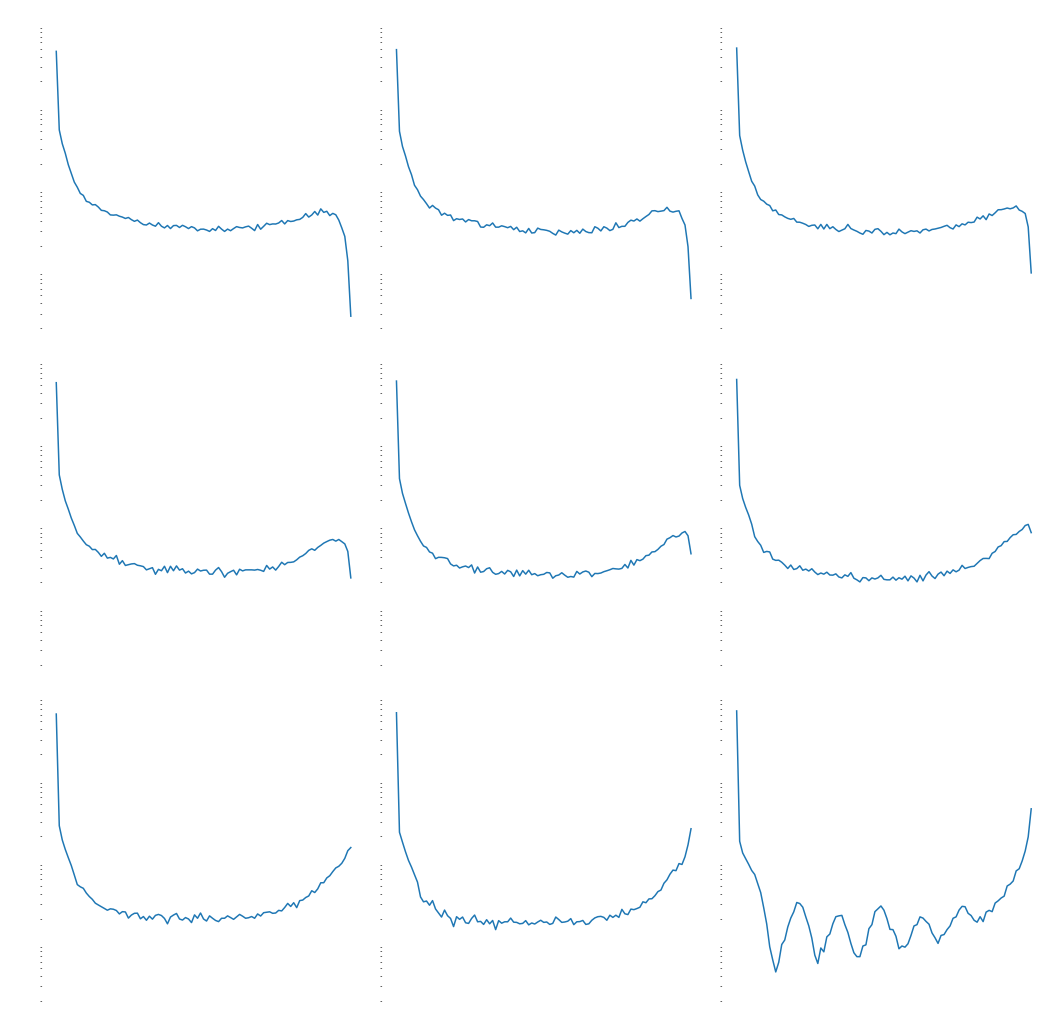

In [413]:
histogram((gaussian24, gaussian22, gaussian20, gaussian18, gaussian16, gaussian14, gaussian12, gaussian10, gaussian8_bimodal), title=['gaussian24', 'gaussian22', 'gaussian20', 'gaussian18', 'gaussian16', 'guassian14', 'gaussian12', 'gaussian10', 'gaussian8_bimodal'], figure_shape=(3, 3), figure_size=(18, 18), vertical_gap=0.1, y_scale='log')

histogram(fs=gaussian10, title='gaussian10', figure_shape=(1, 1), figure_size=(10, 10))

histogram([gaussian12, gaussian10, gaussian8], title=['guassian12', 'gaussian10', 'gaussian8'], figure_shape=(1, 3))

gaussian1 = Average_Neutral_Fraction_Distribution(
    box=noise_box, 
    radius=100, 
    iteration=10**3, 
    shell_num=1,
    blur_shape='Gaussian_sphere'
)

gaussian2 = Average_Neutral_Fraction_Distribution(
    box=noise_box, 
    radius=100, 
    iteration=10**3, 
    shell_num=2,
    blur_shape='Gaussian_sphere'
)

gaussian3 = Average_Neutral_Fraction_Distribution(
    box=noise_box, 
    radius=100, 
    iteration=10**3, 
    shell_num=3,
    blur_shape='Gaussian_sphere'
)

gaussian4 = Average_Neutral_Fraction_Distribution(
    box=noise_box, 
    radius=100, 
    iteration=10**3, 
    shell_num=4,
    blur_shape='Gaussian_sphere'
)

gaussian5 = Average_Neutral_Fraction_Distribution(
    box=noise_box, 
    radius=100, 
    iteration=10**3,
    shell_num=5,
    blur_shape='Gaussian_sphere'
)

gaussian6 = Average_Neutral_Fraction_Distribution(
    box=noise_box, 
    radius=100, 
    iteration=10**3,
    shell_num=6,
    blur_shape='Gaussian_sphere'
)

gaussian7 = Average_Neutral_Fraction_Distribution(
    box=noise_box, 
    radius=100, 
    iteration=10**3,
    shell_num=7,
    blur_shape='Gaussian_sphere'
)

gaussian8 = Average_Neutral_Fraction_Distribution(
    box=noise_box, 
    radius=100, 
    iteration=10**3,
    shell_num=8,
    blur_shape='Gaussian_sphere'
)

histogram(fs=[gaussian1, gaussian2, gaussian3, gaussian4, gaussian5, gaussian6, gaussian7, gaussian8], title=['gaussian1', 'gaussian2', 'gaussian3', 'gaussian4', 'gaussian5', 'gaussian6', 'gaussian7', 'gaussian8'], figure_shape=(2,4), y_scale='linear', vertical_gap=0.15)

# Report to Dr. Furlanetto on the comparisons of stand devs

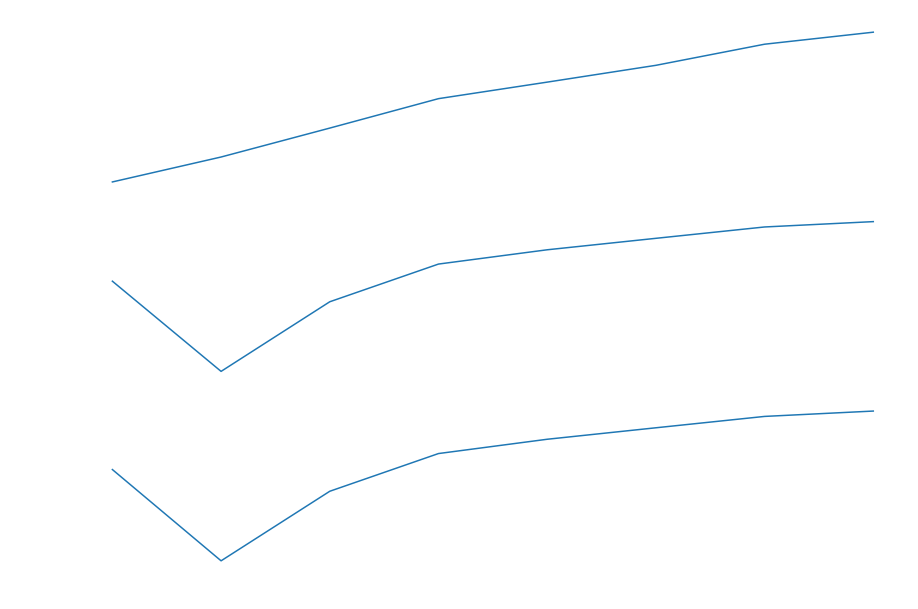

In [401]:
stand_dev1 = np.std(gaussian1)
stand_dev2 = np.std(gaussian2)
stand_dev3 = np.std(gaussian3)
stand_dev4 = np.std(gaussian4)
stand_dev5 = np.std(gaussian5)
stand_dev6 = np.std(gaussian6)
stand_dev7 = np.std(gaussian7)
stand_dev8 = np.std(gaussian8)
# print(stand_dev1)
# print(stand_dev2)
# print(stand_dev3)
# print(stand_dev4)
# print(stand_dev5)
# print(stand_dev6)
# print(stand_dev7)
# print(stand_dev8)
shell_number = np.arange(1, 9)
stand_devs = [stand_dev1, stand_dev2, stand_dev3, stand_dev4, stand_dev5, stand_dev6, stand_dev7, stand_dev8]

std_sphere = np.std(sphere)
std_cube = np.std(cube)

gaussian_sphere = abs((stand_devs-std_sphere)/np.mean([stand_devs, std_sphere]))*100
gaussian_cube = abs((stand_devs-std_cube)/np.mean([stand_devs, std_cube]))*100
abs((std_cube-std_sphere)/np.mean([std_cube, std_sphere]))

plots(fs=(stand_devs, gaussian_sphere, gaussian_cube), x_vals=shell_number, title=('Gaussian Method Standard Deviation', 'Gaussian vs Sphere error', 'Gaussian vs Cube error'), y_label=('', 'percent [%]', 'percent [%]'), figure_shape=(3,1), figure_size=(15,10), vertical_gap=0.15, sharey=False, y_notation=['sci']+['plain']*2)